# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
# plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import tensorflow as tf

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
tensorflow -> {tf.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
tensorflow -> 2.8.0



In [165]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 7]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

# Preparing Time Series Data for Deep Learning

In [4]:
path = Path('../../datasets/Ch13/')

In [5]:
daily_temp = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [6]:
daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

In [7]:
print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


### Visualize the time series data

<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

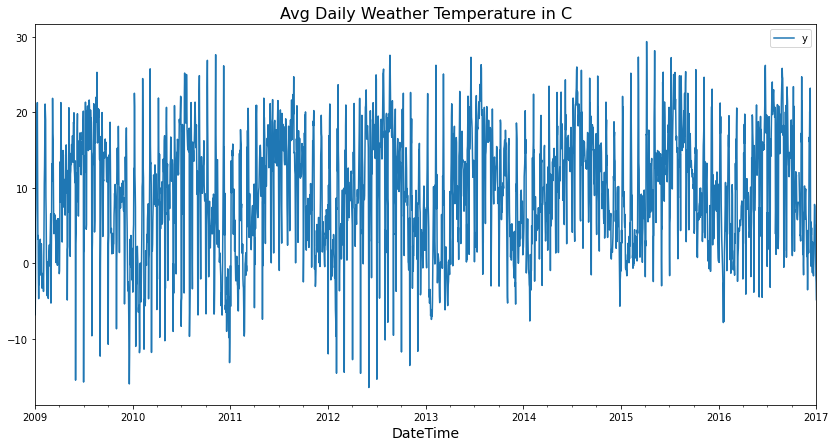

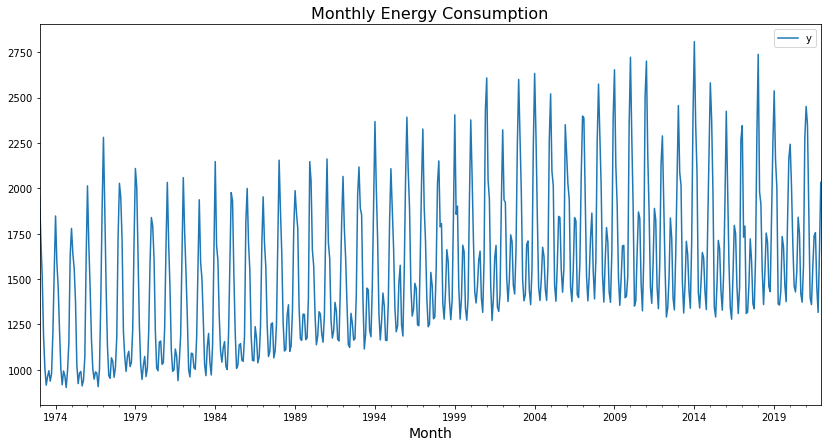

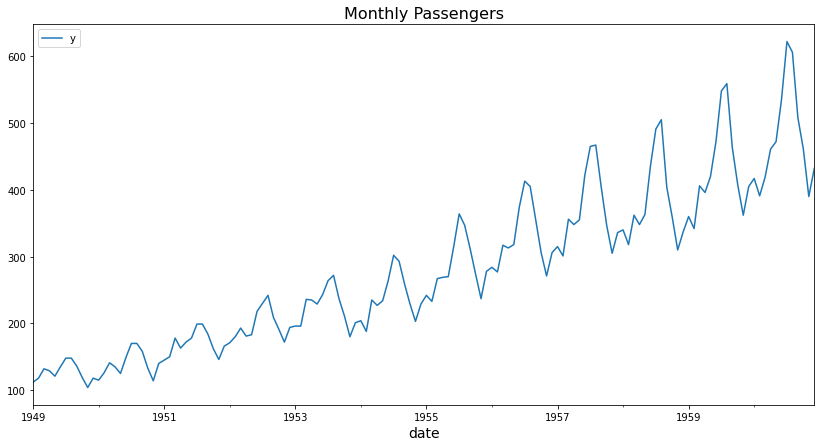

In [166]:
daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')

## Tranform the data sets
### Windowing

In [9]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()

In [10]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [11]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [98]:
air_df = one_step_forecast(air_cp, 10)
en_df = one_step_forecast(en_cp, 10)
dw_df = one_step_forecast(dw_cp, 10)
print(air_df.shape)
print(en_df.shape)
print(dw_df.shape)

(134, 11)
(578, 11)
(2913, 11)


### Scale and split data

In [99]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [100]:
scale_air = Standardize(air_df)
scale_dw = Standardize(dw_df)
scale_en = Standardize(en_df)

train_air, test_air, val_air = scale_air.fit_transform()
train_dw, test_dw, val_dw = scale_dw.fit_transform()
train_en, test_en, val_en = scale_en.fit_transform()

In [101]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 109 , test: 13, val:12
weather: train: 2360 , test: 291, val:262
energy: train: 469 , test: 57, val: 52



In [102]:
train_air.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
date,,,,,,,,,,,
1949-01-31,-1.397191,-1.355576,-1.215965,-1.273158,-1.388829,-1.241504,-1.097475,-1.099026,-1.245575,-1.452102,-1.645982
1949-02-28,-1.327272,-1.191673,-1.251032,-1.366593,-1.225652,-1.092114,-1.097475,-1.228860,-1.428232,-1.613479,-1.494104
1949-03-31,-1.164130,-1.226795,-1.344543,-1.203082,-1.074129,-1.092114,-1.231445,-1.412792,-1.589400,-1.462860,-1.526649
1949-04-30,-1.199089,-1.320454,-1.180898,-1.051250,-1.074129,-1.230012,-1.421237,-1.575085,-1.438977,-1.495136,-1.407316
1949-05-31,-1.292313,-1.156552,-1.028943,-1.051250,-1.213996,-1.425368,-1.588701,-1.423612,-1.471210,-1.376792,-1.244589


In [103]:
scale_air.inverse(train_air).head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
date,,,,,,,,,,,
1949-01-31,112.0,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0
1949-02-28,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0
1949-03-31,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0
1949-04-30,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0
1949-05-31,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0


In [104]:
scale_air.inverse_y(train_air.iloc[:, -1]).head()

date
1949-01-31    104.0
1949-02-28    118.0
1949-03-31    115.0
1949-04-30    126.0
1949-05-31    141.0
Freq: M, Name: y, dtype: float64

### Split into X and Y (Features and Target)

In [105]:
def features_target_ts(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [106]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target_ts(train_air, 
                               val_air, 
                               test_air)

In [107]:
(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target_ts(train_dw, 
                             val_dw, 
                             test_dw)

In [108]:
(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_ts(train_en, 
                             val_en, 
                             test_en)

In [111]:
scale_air.inverse_y(y_train_air)[0:5]

array([[104.],
       [118.],
       [115.],
       [126.],
       [141.]])

In [112]:
x_train_air.shape

(109, 10, 1)

In [113]:
type(x_train_air)

numpy.ndarray

In [114]:
print(y_train_air.shape,
y_test_air.shape,
y_val_air.shape)

(109, 1) (13, 1) (12, 1)


### Using Scikit-Learn for Scaling and Splitting

In [115]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

In [116]:
# train, test = train_test_split(air_d, test_size=0.15, shuffle=False)
# train, val = train_test_split(train, test_size=0.15, shuffle=False)

In [117]:
# scale = StandardScaler()
# scale.fit(train)

In [118]:
# train_scaled = scale.transform(train)
# test_scaled = scale.transform(test)
# val_scaled = scale.transform(val)

In [119]:
# x_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
# x_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]
# x_val, y_val = val_scaled[:, :-1], val_scaled[:, -1]

----
# Forecasting with Keras

In [28]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout)

## SimpleRNN

In [200]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [121]:
def train_model_ts(model, 
                x_train, y_train, x_val, y_val, 
                epochs=500, 
                patience=12, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), 
                           MeanAbsoluteError()])
    
    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss", 
                    min_delta=0, 
                    patience=patience)
    
    history = model.fit(x_train,y_train, 
              shuffle=False, epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [187]:
def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Loss by Epoch',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                title='Forecast vs Actual',
                                label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(
            style='k',label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()

**Another version to plot three subplots for performance measure in RMSE, MAE, and forecast**

In [178]:
# def plot_forecast(model, x_test, y_test, index, history):
#     plt.figure(figsize=(20, 10))
#     ax1 = plt.subplot2grid((2, 2), (0, 0))
#     pd.Series(history.history['root_mean_squared_error']).plot(style='k',
#                                                                alpha=0.50,
#                                                                ax=ax1, 
#                                                                title='RMSE by EPOCH',
#                                                               label='rmse')
#     pd.Series(history.history['val_root_mean_squared_error']).plot(style='k',
#                                                                    ax=ax1,
#                                                                   label='val_rmse')
#     plt.legend()

#     ax2 = plt.subplot2grid((2, 2), (0, 1))
#     pd.Series(history.history['mean_absolute_error']).plot(style='k',
#                                                            alpha=0.50,
#                                                            ax=ax2,
#                                                           title='MAE by EPOCH',
#                                                           label='mae')
#     pd.Series(history.history['val_mean_absolute_error']).plot(style='k',
#                                                                ax=ax2,
#                                                               label='val_mae')
#     plt.legend()
#     ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
#     predicted = model.predict(x_test)
#     pd.Series(y_test.reshape(-1), 
#               index=index).plot(style='k--', alpha=0.5, ax=ax3, 
#                                 title='Forecast vs Actual',
#                                label='actual')
#     pd.Series(predicted.reshape(-1), 
#               index=index).plot(style='k', label='Forecast', ax=ax3)
#     plt.legend();plt.show()


### Air Passenger

In [179]:
tf.keras.backend.clear_session()

In [180]:
model_a_simpleRNN = create_model(train=x_train_air, units=32)

In [181]:
model_a_simpleRNN

In [182]:
model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [183]:
history_a_simpleRNN = train_model_ts(model_a_simpleRNN, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 1s 73ms/step - loss: 1.6343 - root_mean_squared_error: 1.2784 - mean_absolute_error: 1.0822 - val_loss: 4.5748 - val_root_mean_squared_error: 2.1389 - val_mean_absolute_error: 1.9734
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 1.0111 - root_mean_squared_error: 1.0056 - mean_absolute_error: 0.8202 - val_loss: 3.1836 - val_root_mean_squared_error: 1.7843 - val_mean_absolute_error: 1.5856
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 0.5341 - root_mean_squared_error: 0.7308 - mean_absolute_error: 0.5833 - val_loss: 2.0795 - val_root_mean_squared_error: 1.4421 - val_mean_absolute_error: 1.1934
Epoch 4/500
4/4 [==============================] - 0s 11ms/step - loss: 0.4138 - root_mean_squared_error: 0.6432 - mean_absolute_error: 0.4812 - val_loss: 1.3383 - val_root_mean_squared_error: 1.1569 - val_mean_absolute_error: 0.8670
Epoch 5/500
4/4 [==============================] - 0s 11ms/step 

In [184]:
history_a_simpleRNN.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error'])

In [185]:
model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 17ms/step - loss: 1.2067 - root_mean_squared_error: 1.0985 - mean_absolute_error: 0.9740


[1.2066876888275146, 1.0984933376312256, 0.9740179777145386]

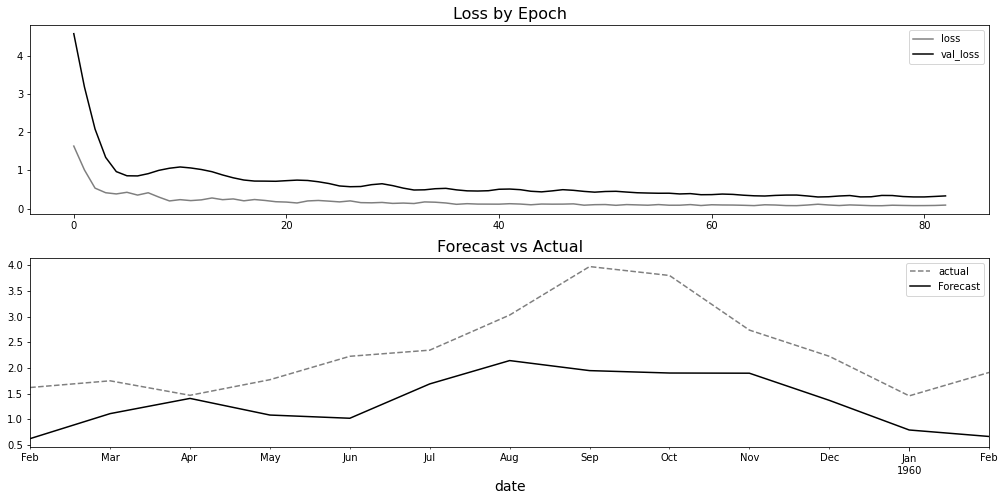

In [188]:
plot_forecast(model_a_simpleRNN, x_test_air, y_test_air, test_air.index, history_a_simpleRNN)

### Avg Daily Temp

In [155]:
tf.keras.backend.clear_session()

In [156]:
model_dw_simpleRNN = create_model(x_train_dw, units=32)

In [157]:
model_dw_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [159]:
history_dw_simpleRNN = train_model_ts(model_dw_simpleRNN, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 1s 9ms/step - loss: 0.4990 - root_mean_squared_error: 0.7064 - mean_absolute_error: 0.5201 - val_loss: 0.3798 - val_root_mean_squared_error: 0.6163 - val_mean_absolute_error: 0.4725
Epoch 2/500
37/37 [==============================] - 0s 4ms/step - loss: 0.4531 - root_mean_squared_error: 0.6731 - mean_absolute_error: 0.4810 - val_loss: 0.3818 - val_root_mean_squared_error: 0.6179 - val_mean_absolute_error: 0.4709
Epoch 3/500
37/37 [==============================] - 0s 4ms/step - loss: 0.4368 - root_mean_squared_error: 0.6609 - mean_absolute_error: 0.4736 - val_loss: 0.3816 - val_root_mean_squared_error: 0.6177 - val_mean_absolute_error: 0.4738
Epoch 4/500
37/37 [==============================] - 0s 4ms/step - loss: 0.4388 - root_mean_squared_error: 0.6624 - mean_absolute_error: 0.4727 - val_loss: 0.3846 - val_root_mean_squared_error: 0.6201 - val_mean_absolute_error: 0.4713
Epoch 5/500
37/37 [==============================] - 0s 4ms/

In [160]:
model_dw_simpleRNN.evaluate(x=x_test_dw, y=y_test_dw)

10/10 [==============================] - 0s 2ms/step - loss: 0.3719 - root_mean_squared_error: 0.6099 - mean_absolute_error: 0.4426


[0.3719228208065033, 0.6098547577857971, 0.4426104426383972]

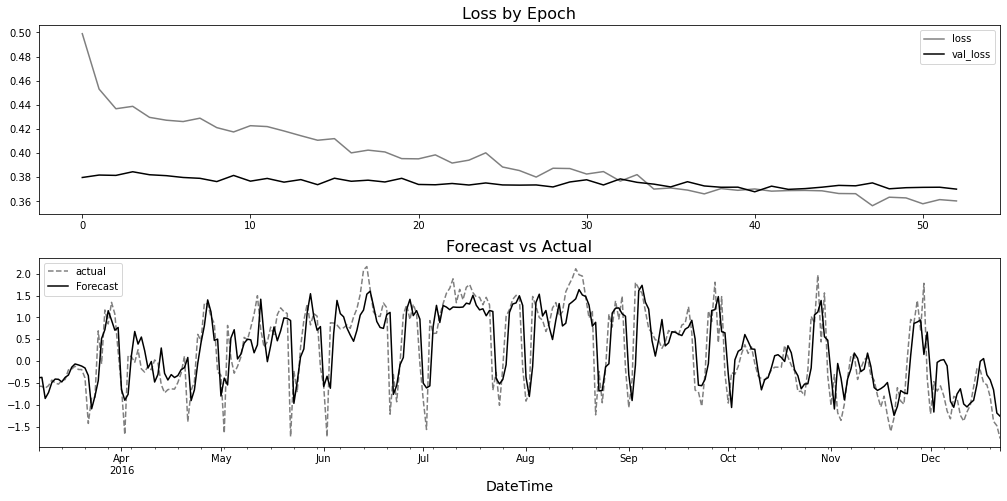

In [189]:
plot_forecast(model_dw_simpleRNN, x_test_dw, y_test_dw, test_dw.index, history_dw_simpleRNN)

### Energy Consumption

In [201]:
tf.keras.backend.clear_session()

In [202]:
model_en_simpleRNN = create_model(x_train_en, units=32)
model_en_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [203]:
history_en_simpleRNN = train_model_ts(model_en_simpleRNN, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 [==============================] - 1s 28ms/step - loss: 1.3298 - root_mean_squared_error: 1.1532 - mean_absolute_error: 0.9231 - val_loss: 1.4112 - val_root_mean_squared_error: 1.1880 - val_mean_absolute_error: 0.9029
Epoch 2/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8550 - root_mean_squared_error: 0.9247 - mean_absolute_error: 0.7575 - val_loss: 0.9295 - val_root_mean_squared_error: 0.9641 - val_mean_absolute_error: 0.7614
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6117 - root_mean_squared_error: 0.7821 - mean_absolute_error: 0.6418 - val_loss: 0.6052 - val_root_mean_squared_error: 0.7779 - val_mean_absolute_error: 0.6242
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4574 - root_mean_squared_error: 0.6763 - mean_absolute_error: 0.5419 - val_loss: 0.4154 - val_root_mean_squared_error: 0.6445 - val_mean_absolute_error: 0.5149
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - lo

In [204]:
model_en_simpleRNN.evaluate(x=x_test_en, y=y_test_en)

2/2 [==============================] - 0s 3ms/step - loss: 0.1093 - root_mean_squared_error: 0.3306 - mean_absolute_error: 0.2686


[0.10928848385810852, 0.33058810234069824, 0.26855143904685974]

In [205]:
y_test_air.shape

(13, 1)

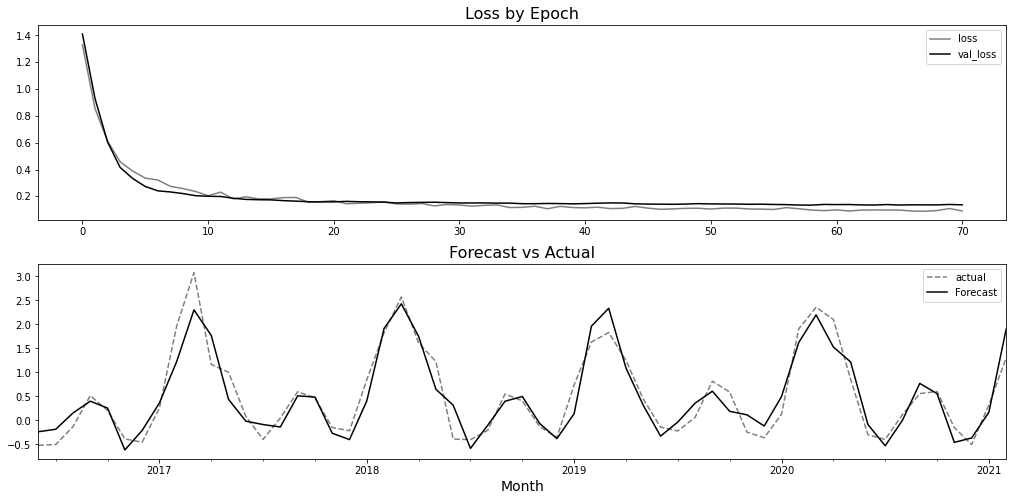

In [206]:
plot_forecast(model_en_simpleRNN, x_test_en, y_test_en, test_en.index, history_en_simpleRNN)

In [198]:
scale_en.inverse_y(y_test_en[0:5])

array([[1309.744],
       [1316.979],
       [1463.766],
       [1721.174],
       [1598.033]])

In [199]:
scale_en.inverse_y(model_en_simpleRNN.predict(x_test_en)[0:5])

array([[1366.8953],
       [1505.3137],
       [1517.4086],
       [1686.1849],
       [1623.1412]], dtype=float32)

In [ ]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(keras.layers.Lin)
    
    return model

## LSTM

In [242]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [243]:
tf.keras.backend.clear_session()

In [244]:
model_a_lstm = create_model(train=x_train_air, units=32)
model_a_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [247]:
history_a_lstm = train_model_ts(model_a_lstm, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 2s 136ms/step - loss: 0.7443 - root_mean_squared_error: 0.8627 - mean_absolute_error: 0.6967 - val_loss: 2.7995 - val_root_mean_squared_error: 1.6732 - val_mean_absolute_error: 1.4775
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 0.6468 - root_mean_squared_error: 0.8042 - mean_absolute_error: 0.6355 - val_loss: 2.3544 - val_root_mean_squared_error: 1.5344 - val_mean_absolute_error: 1.3156
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 0.5140 - root_mean_squared_error: 0.7169 - mean_absolute_error: 0.5589 - val_loss: 1.9479 - val_root_mean_squared_error: 1.3957 - val_mean_absolute_error: 1.1475
Epoch 4/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4523 - root_mean_squared_error: 0.6725 - mean_absolute_error: 0.5233 - val_loss: 1.5940 - val_root_mean_squared_error: 1.2625 - val_mean_absolute_error: 0.9770
Epoch 5/500
4/4 [==============================] - 0s 12ms/step

In [248]:
model_a_lstm.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 20ms/step - loss: 1.2298 - root_mean_squared_error: 1.1090 - mean_absolute_error: 0.8117


[1.2298158407211304, 1.1089706420898438, 0.8116564154624939]

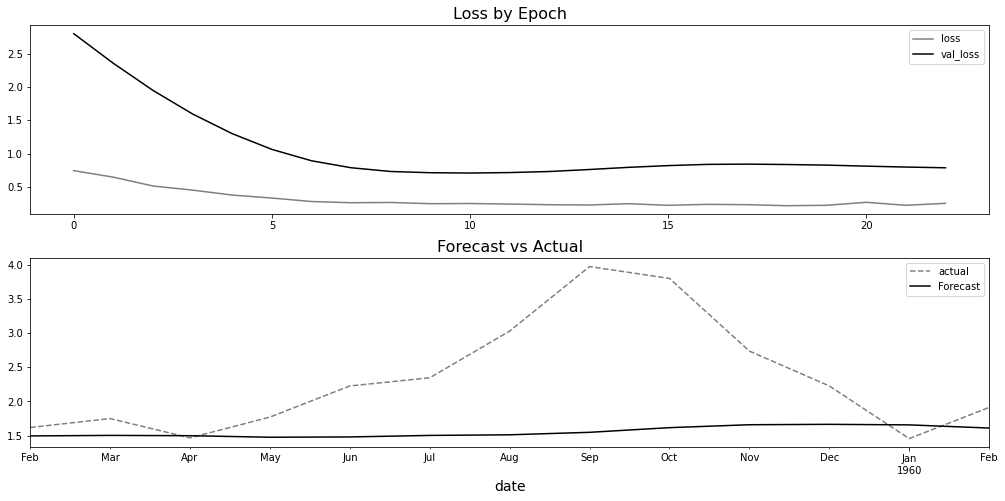

In [249]:
plot_forecast(model_a_lstm, x_test_air, y_test_air, test_air.index, history_a_lstm)

### Avg Daily Temp

In [250]:
tf.keras.backend.clear_session()

In [251]:
model_dw_lstm = create_model(train=x_train_dw, units=32)
model_dw_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [252]:
history_dw_lstm = train_model_ts(model_dw_lstm, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 2s 18ms/step - loss: 0.7165 - root_mean_squared_error: 0.8465 - mean_absolute_error: 0.6657 - val_loss: 0.5705 - val_root_mean_squared_error: 0.7553 - val_mean_absolute_error: 0.6046
Epoch 2/500
37/37 [==============================] - 0s 6ms/step - loss: 0.6467 - root_mean_squared_error: 0.8042 - mean_absolute_error: 0.6139 - val_loss: 0.5187 - val_root_mean_squared_error: 0.7202 - val_mean_absolute_error: 0.5760
Epoch 3/500
37/37 [==============================] - 0s 7ms/step - loss: 0.5983 - root_mean_squared_error: 0.7735 - mean_absolute_error: 0.5867 - val_loss: 0.4771 - val_root_mean_squared_error: 0.6908 - val_mean_absolute_error: 0.5524
Epoch 4/500
37/37 [==============================] - 0s 7ms/step - loss: 0.5559 - root_mean_squared_error: 0.7456 - mean_absolute_error: 0.5596 - val_loss: 0.4416 - val_root_mean_squared_error: 0.6646 - val_mean_absolute_error: 0.5304
Epoch 5/500
37/37 [==============================] - 0s 7ms

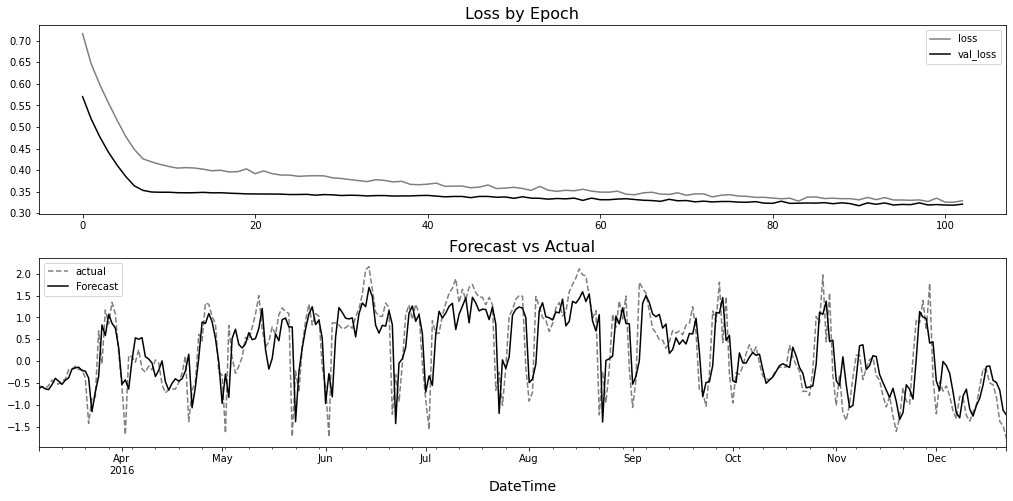

In [253]:
plot_forecast(model_dw_lstm, x_test_dw, y_test_dw, test_dw.index, history_dw_lstm)

### Energy Consumption

In [254]:
tf.keras.backend.clear_session()

In [255]:
model_en_lstm = create_model(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [257]:
history_en_lstm = train_model_ts(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 [==============================] - 3s 73ms/step - loss: 0.9755 - root_mean_squared_error: 0.9877 - mean_absolute_error: 0.8043 - val_loss: 1.3377 - val_root_mean_squared_error: 1.1566 - val_mean_absolute_error: 0.8451
Epoch 2/500
8/8 [==============================] - 0s 9ms/step - loss: 0.9417 - root_mean_squared_error: 0.9704 - mean_absolute_error: 0.7910 - val_loss: 1.3060 - val_root_mean_squared_error: 1.1428 - val_mean_absolute_error: 0.8412
Epoch 3/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9109 - root_mean_squared_error: 0.9544 - mean_absolute_error: 0.7783 - val_loss: 1.2746 - val_root_mean_squared_error: 1.1290 - val_mean_absolute_error: 0.8365
Epoch 4/500
8/8 [==============================] - 0s 8ms/step - loss: 0.8976 - root_mean_squared_error: 0.9474 - mean_absolute_error: 0.7758 - val_loss: 1.2461 - val_root_mean_squared_error: 1.1163 - val_mean_absolute_error: 0.8315
Epoch 5/500
8/8 [==============================] - 0s 7ms/step - lo

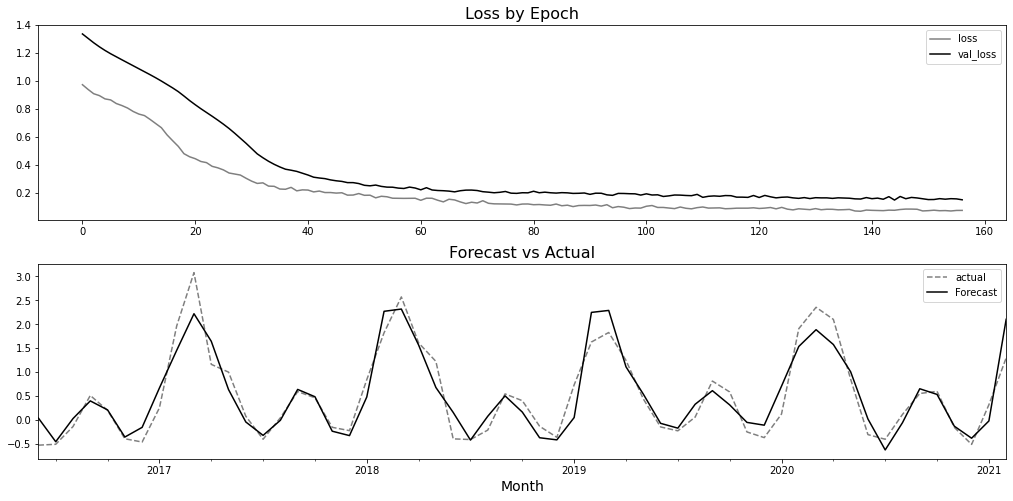

In [258]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

## GRU

In [268]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units,
                  input_shape=(train.shape[1], 
                               train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [269]:
tf.keras.backend.clear_session()

In [271]:
model_a_gru = create_model(train=x_train_air, units=32)
history_a_gru = train_model_ts(model_a_gru, x_train_air, y_train_air, x_val_air, y_val_air)


Epoch 1/500
4/4 [==============================] - 2s 146ms/step - loss: 1.3209 - root_mean_squared_error: 1.1493 - mean_absolute_error: 0.9539 - val_loss: 4.5174 - val_root_mean_squared_error: 2.1254 - val_mean_absolute_error: 1.9456
Epoch 2/500
4/4 [==============================] - 0s 16ms/step - loss: 1.1176 - root_mean_squared_error: 1.0572 - mean_absolute_error: 0.8790 - val_loss: 3.8824 - val_root_mean_squared_error: 1.9704 - val_mean_absolute_error: 1.7799
Epoch 3/500
4/4 [==============================] - 0s 17ms/step - loss: 1.0022 - root_mean_squared_error: 1.0011 - mean_absolute_error: 0.8091 - val_loss: 3.2672 - val_root_mean_squared_error: 1.8076 - val_mean_absolute_error: 1.6021
Epoch 4/500
4/4 [==============================] - 0s 16ms/step - loss: 0.7406 - root_mean_squared_error: 0.8606 - mean_absolute_error: 0.6926 - val_loss: 2.6919 - val_root_mean_squared_error: 1.6407 - val_mean_absolute_error: 1.4146
Epoch 5/500
4/4 [==============================] - 0s 14ms/step

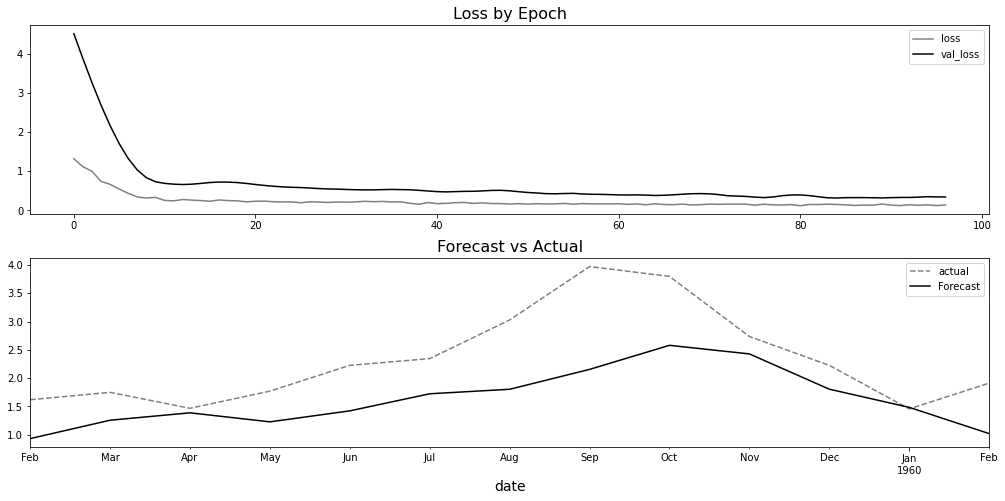

In [272]:
plot_forecast(model_a_gru, x_test_air, y_test_air, test_air.index, history_a_gru)

### Avg Daily Temp

In [273]:
tf.keras.backend.clear_session()

In [274]:
model_dw_gru = create_model(train=x_train_dw, units=32)
history_dw_gru = train_model_ts(model_dw_gru, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 2s 17ms/step - loss: 1.1890 - root_mean_squared_error: 1.0904 - mean_absolute_error: 0.8955 - val_loss: 0.7541 - val_root_mean_squared_error: 0.8684 - val_mean_absolute_error: 0.7198
Epoch 2/500
37/37 [==============================] - 0s 7ms/step - loss: 0.7822 - root_mean_squared_error: 0.8844 - mean_absolute_error: 0.6941 - val_loss: 0.5720 - val_root_mean_squared_error: 0.7563 - val_mean_absolute_error: 0.6015
Epoch 3/500
37/37 [==============================] - 0s 7ms/step - loss: 0.6543 - root_mean_squared_error: 0.8089 - mean_absolute_error: 0.6153 - val_loss: 0.5015 - val_root_mean_squared_error: 0.7082 - val_mean_absolute_error: 0.5629
Epoch 4/500
37/37 [==============================] - 0s 7ms/step - loss: 0.5849 - root_mean_squared_error: 0.7648 - mean_absolute_error: 0.5756 - val_loss: 0.4528 - val_root_mean_squared_error: 0.6729 - val_mean_absolute_error: 0.5342
Epoch 5/500
37/37 [==============================] - 0s 7ms

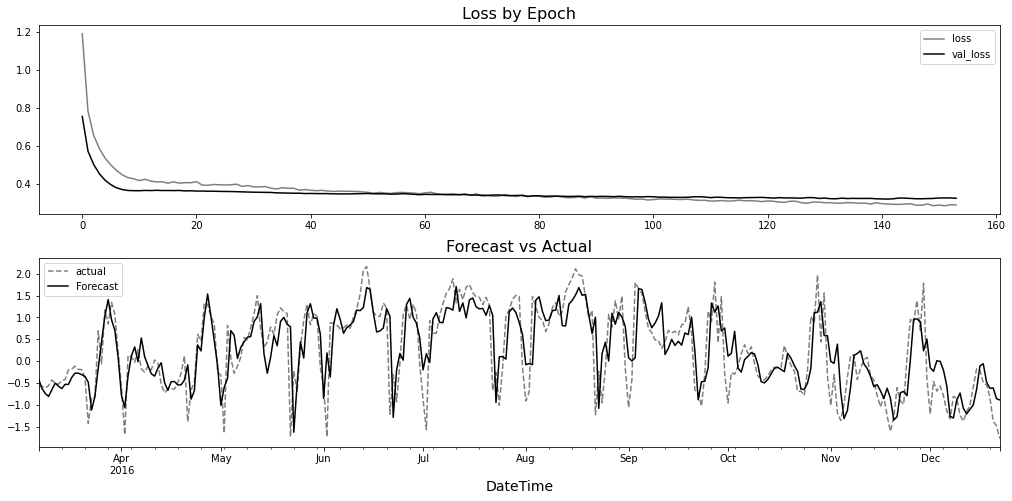

In [275]:
plot_forecast(model_dw_gru, x_test_dw, y_test_dw, test_dw.index, history_dw_gru)

### Energy Consumption

In [276]:
tf.keras.backend.clear_session()

In [277]:
model_en_gru = create_model(x_train_en, units=32)
model_en_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [278]:
history_en_gru = train_model_ts(model_en_gru, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 [==============================] - 2s 66ms/step - loss: 0.8800 - root_mean_squared_error: 0.9381 - mean_absolute_error: 0.7609 - val_loss: 1.1974 - val_root_mean_squared_error: 1.0942 - val_mean_absolute_error: 0.8119
Epoch 2/500
8/8 [==============================] - 0s 9ms/step - loss: 0.8138 - root_mean_squared_error: 0.9021 - mean_absolute_error: 0.7278 - val_loss: 1.1292 - val_root_mean_squared_error: 1.0626 - val_mean_absolute_error: 0.7945
Epoch 3/500
8/8 [==============================] - 0s 10ms/step - loss: 0.7466 - root_mean_squared_error: 0.8640 - mean_absolute_error: 0.6971 - val_loss: 1.0602 - val_root_mean_squared_error: 1.0297 - val_mean_absolute_error: 0.7757
Epoch 4/500
8/8 [==============================] - 0s 9ms/step - loss: 0.7141 - root_mean_squared_error: 0.8450 - mean_absolute_error: 0.6855 - val_loss: 0.9995 - val_root_mean_squared_error: 0.9997 - val_mean_absolute_error: 0.7593
Epoch 5/500
8/8 [==============================] - 0s 8ms/step - l

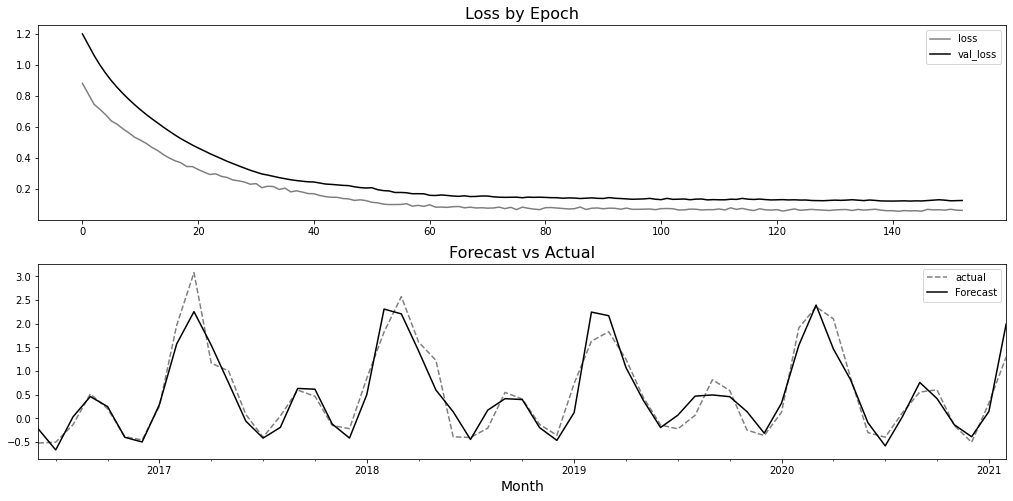

In [279]:
plot_forecast(model_en_gru, x_test_en, y_test_en, test_en.index, history_en_gru)

## Deep RNN-LSTM

### Air Passenger

In [280]:
tf.keras.backend.clear_session()

In [281]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [283]:
model_a_deep = create_model(train=x_train_air, units=32)
history_a_deep = train_model_ts(model_a_deep, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 5s 249ms/step - loss: 0.9255 - root_mean_squared_error: 0.9620 - mean_absolute_error: 0.7928 - val_loss: 3.2550 - val_root_mean_squared_error: 1.8041 - val_mean_absolute_error: 1.6253
Epoch 2/500
4/4 [==============================] - 0s 19ms/step - loss: 0.7551 - root_mean_squared_error: 0.8689 - mean_absolute_error: 0.7050 - val_loss: 2.7288 - val_root_mean_squared_error: 1.6519 - val_mean_absolute_error: 1.4492
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.6312 - root_mean_squared_error: 0.7945 - mean_absolute_error: 0.6329 - val_loss: 2.2108 - val_root_mean_squared_error: 1.4869 - val_mean_absolute_error: 1.2508
Epoch 4/500
4/4 [==============================] - 0s 17ms/step - loss: 0.5170 - root_mean_squared_error: 0.7190 - mean_absolute_error: 0.5591 - val_loss: 1.7124 - val_root_mean_squared_error: 1.3086 - val_mean_absolute_error: 1.0228
Epoch 5/500
4/4 [==============================] - 0s 18ms/step

In [284]:
model_a_deep.evaluate(x_test_air, y_test_air)

1/1 [==============================] - 0s 24ms/step - loss: 1.3527 - root_mean_squared_error: 1.1630 - mean_absolute_error: 0.8436


[1.3526619672775269, 1.1630399227142334, 0.8435776829719543]

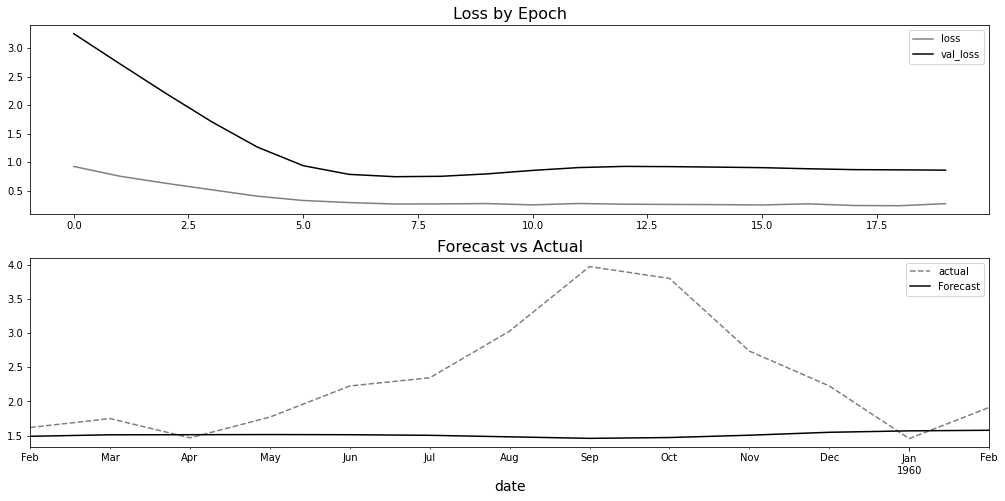

In [285]:
plot_forecast(model_a_deep, x_test_air, y_test_air, test_air.index, history_a_deep)

### Avg Daily Temp

In [287]:
tf.keras.backend.clear_session()

Epoch 1/500
37/37 [==============================] - 4s 31ms/step - loss: 0.8673 - root_mean_squared_error: 0.9313 - mean_absolute_error: 0.7485 - val_loss: 0.7131 - val_root_mean_squared_error: 0.8444 - val_mean_absolute_error: 0.6816
Epoch 2/500
37/37 [==============================] - 0s 11ms/step - loss: 0.7967 - root_mean_squared_error: 0.8926 - mean_absolute_error: 0.6983 - val_loss: 0.6679 - val_root_mean_squared_error: 0.8172 - val_mean_absolute_error: 0.6598
Epoch 3/500
37/37 [==============================] - 0s 11ms/step - loss: 0.7555 - root_mean_squared_error: 0.8692 - mean_absolute_error: 0.6755 - val_loss: 0.6176 - val_root_mean_squared_error: 0.7859 - val_mean_absolute_error: 0.6327
Epoch 4/500
37/37 [==============================] - 0s 11ms/step - loss: 0.6970 - root_mean_squared_error: 0.8349 - mean_absolute_error: 0.6455 - val_loss: 0.5482 - val_root_mean_squared_error: 0.7404 - val_mean_absolute_error: 0.5918
Epoch 5/500
37/37 [==============================] - 0s 

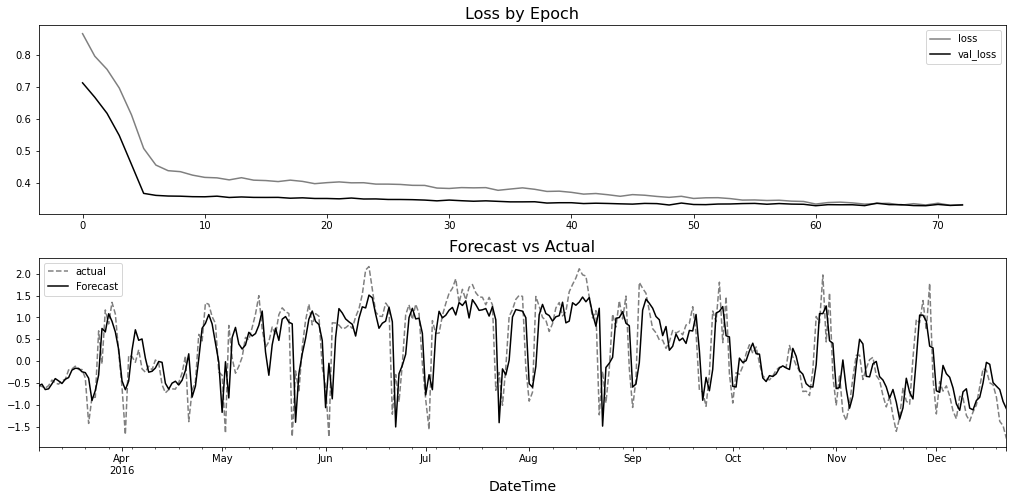

In [286]:
model_dw_deep = create_model(x_train_dw, units=32)
history_dw_deep = train_model_ts(model_dw_deep, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)
plot_forecast(model_dw_deep, x_test_dw, y_test_dw, test_dw.index, history_dw_deep)

### Energy Consumption

In [288]:
tf.keras.backend.clear_session()

Epoch 1/500
8/8 [==============================] - 4s 116ms/step - loss: 1.0130 - root_mean_squared_error: 1.0065 - mean_absolute_error: 0.8184 - val_loss: 1.3871 - val_root_mean_squared_error: 1.1778 - val_mean_absolute_error: 0.8616
Epoch 2/500
8/8 [==============================] - 0s 16ms/step - loss: 0.9867 - root_mean_squared_error: 0.9933 - mean_absolute_error: 0.8116 - val_loss: 1.3652 - val_root_mean_squared_error: 1.1684 - val_mean_absolute_error: 0.8641
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 0.9767 - root_mean_squared_error: 0.9883 - mean_absolute_error: 0.8135 - val_loss: 1.3456 - val_root_mean_squared_error: 1.1600 - val_mean_absolute_error: 0.8661
Epoch 4/500
8/8 [==============================] - 0s 15ms/step - loss: 0.9684 - root_mean_squared_error: 0.9841 - mean_absolute_error: 0.8121 - val_loss: 1.3303 - val_root_mean_squared_error: 1.1534 - val_mean_absolute_error: 0.8660
Epoch 5/500
8/8 [==============================] - 0s 15ms/step

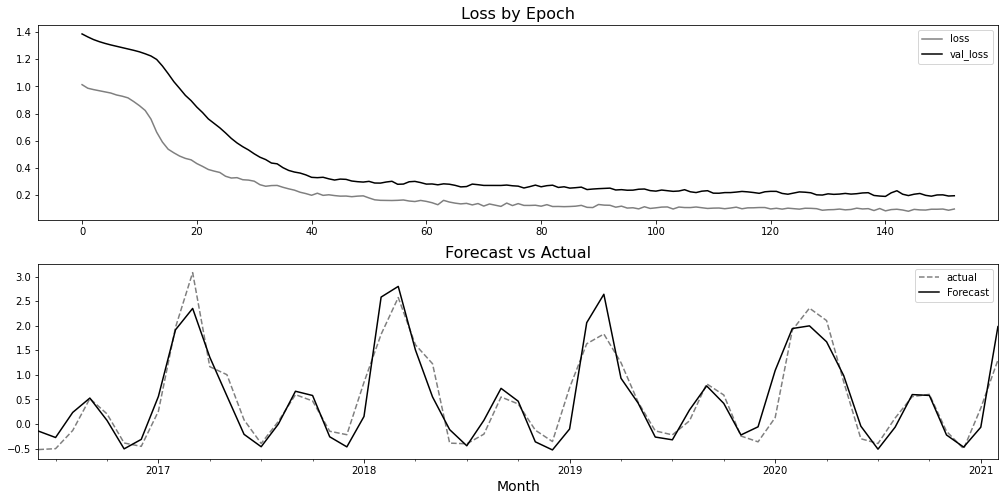

In [289]:
model_en_deep = create_model(x_train_en, units=32)
history_en_deep = train_model_ts(model_en_deep, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_deep, x_test_en, y_test_en, test_en.index, history_en_deep)

## Bidirectional

In [290]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(units=units, 
                                 input_shape=(train.shape[1], train.shape[2]), return_sequences=True)))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [102]:
tf.keras.backend.clear_session()

In [291]:
model_a_bd = create_model(train=x_train_air, units=32)
history_a_bd = train_model_ts(model_a_bd, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 8s 552ms/step - loss: 1.0003 - root_mean_squared_error: 1.0002 - mean_absolute_error: 0.8286 - val_loss: 3.0970 - val_root_mean_squared_error: 1.7598 - val_mean_absolute_error: 1.5765
Epoch 2/500
4/4 [==============================] - 0s 22ms/step - loss: 0.6631 - root_mean_squared_error: 0.8143 - mean_absolute_error: 0.6528 - val_loss: 2.1158 - val_root_mean_squared_error: 1.4546 - val_mean_absolute_error: 1.2217
Epoch 3/500
4/4 [==============================] - 0s 24ms/step - loss: 0.4464 - root_mean_squared_error: 0.6682 - mean_absolute_error: 0.5230 - val_loss: 1.3504 - val_root_mean_squared_error: 1.1621 - val_mean_absolute_error: 0.8553
Epoch 4/500
4/4 [==============================] - 0s 29ms/step - loss: 0.3067 - root_mean_squared_error: 0.5538 - mean_absolute_error: 0.4336 - val_loss: 0.8636 - val_root_mean_squared_error: 0.9293 - val_mean_absolute_error: 0.6942
Epoch 5/500
4/4 [==============================] - 0s 23ms/step

In [292]:
model_a_bd.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 21ms/step - loss: 1.2084 - root_mean_squared_error: 1.0993 - mean_absolute_error: 0.8059


[1.2084084749221802, 1.0992763042449951, 0.8059062957763672]

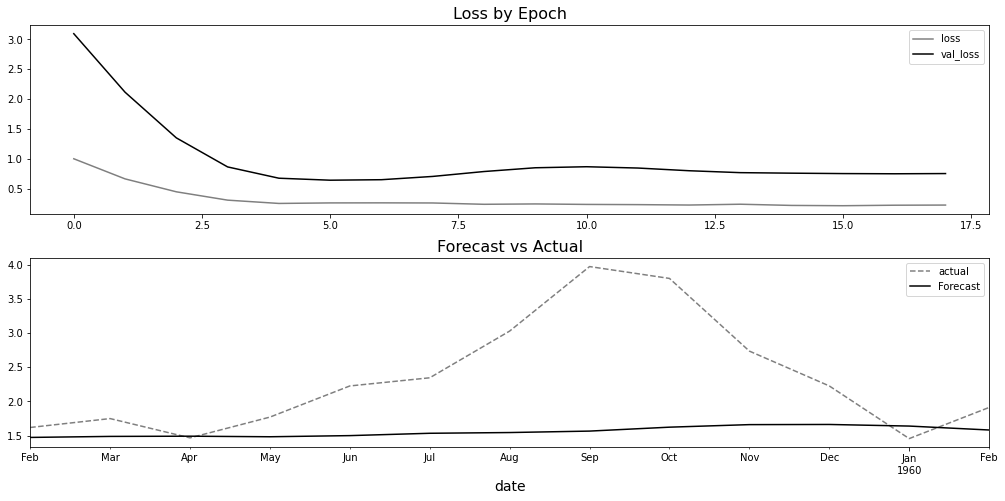

In [293]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [294]:
tf.keras.backend.clear_session()

In [295]:
model_dw_bd = create_model(x_train_dw, units=32)
history_dw_bd = train_model_ts(model_dw_bd, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 9s 52ms/step - loss: 0.7882 - root_mean_squared_error: 0.8878 - mean_absolute_error: 0.6904 - val_loss: 0.5719 - val_root_mean_squared_error: 0.7562 - val_mean_absolute_error: 0.5973
Epoch 2/500
37/37 [==============================] - 0s 13ms/step - loss: 0.6298 - root_mean_squared_error: 0.7936 - mean_absolute_error: 0.5962 - val_loss: 0.4594 - val_root_mean_squared_error: 0.6778 - val_mean_absolute_error: 0.5338
Epoch 3/500
37/37 [==============================] - 0s 13ms/step - loss: 0.5229 - root_mean_squared_error: 0.7231 - mean_absolute_error: 0.5340 - val_loss: 0.3817 - val_root_mean_squared_error: 0.6178 - val_mean_absolute_error: 0.4843
Epoch 4/500
37/37 [==============================] - 0s 13ms/step - loss: 0.4484 - root_mean_squared_error: 0.6696 - mean_absolute_error: 0.4857 - val_loss: 0.3545 - val_root_mean_squared_error: 0.5954 - val_mean_absolute_error: 0.4602
Epoch 5/500
37/37 [==============================] - 0s 

In [296]:
x_test_dw.shape

(291, 10, 1)

In [297]:
model_dw_bd.predict(x_test_dw).shape

(291, 1)

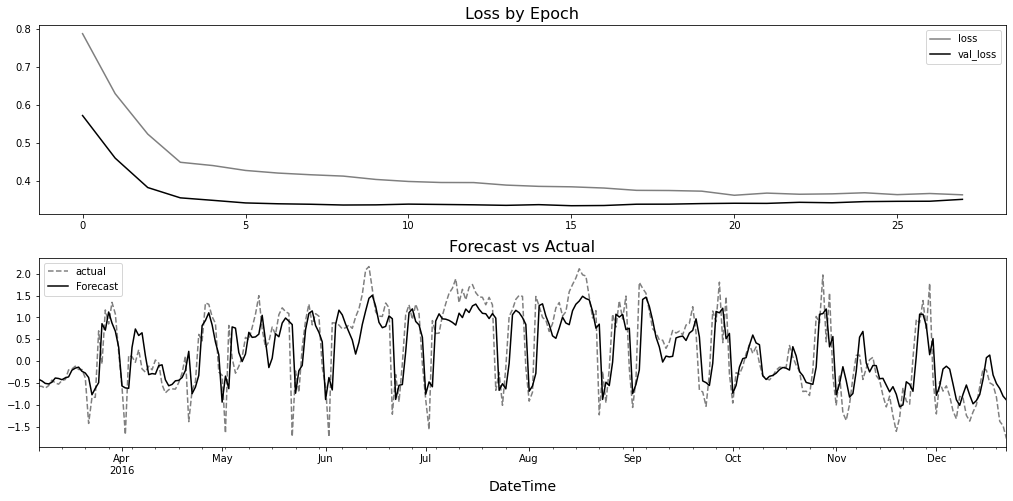

In [298]:
plot_forecast(model_dw_bd, x_test_dw, y_test_dw, test_dw.index, history_dw_bd)

### Energy Consumption

In [299]:
tf.keras.backend.clear_session()

Epoch 1/500
8/8 [==============================] - 7s 203ms/step - loss: 0.9935 - root_mean_squared_error: 0.9967 - mean_absolute_error: 0.8133 - val_loss: 1.3429 - val_root_mean_squared_error: 1.1588 - val_mean_absolute_error: 0.8599
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 0.9306 - root_mean_squared_error: 0.9647 - mean_absolute_error: 0.7935 - val_loss: 1.2781 - val_root_mean_squared_error: 1.1305 - val_mean_absolute_error: 0.8561
Epoch 3/500
8/8 [==============================] - 0s 16ms/step - loss: 0.8929 - root_mean_squared_error: 0.9449 - mean_absolute_error: 0.7818 - val_loss: 1.2269 - val_root_mean_squared_error: 1.1077 - val_mean_absolute_error: 0.8492
Epoch 4/500
8/8 [==============================] - 0s 18ms/step - loss: 0.8656 - root_mean_squared_error: 0.9304 - mean_absolute_error: 0.7681 - val_loss: 1.1818 - val_root_mean_squared_error: 1.0871 - val_mean_absolute_error: 0.8374
Epoch 5/500
8/8 [==============================] - 0s 19ms/step

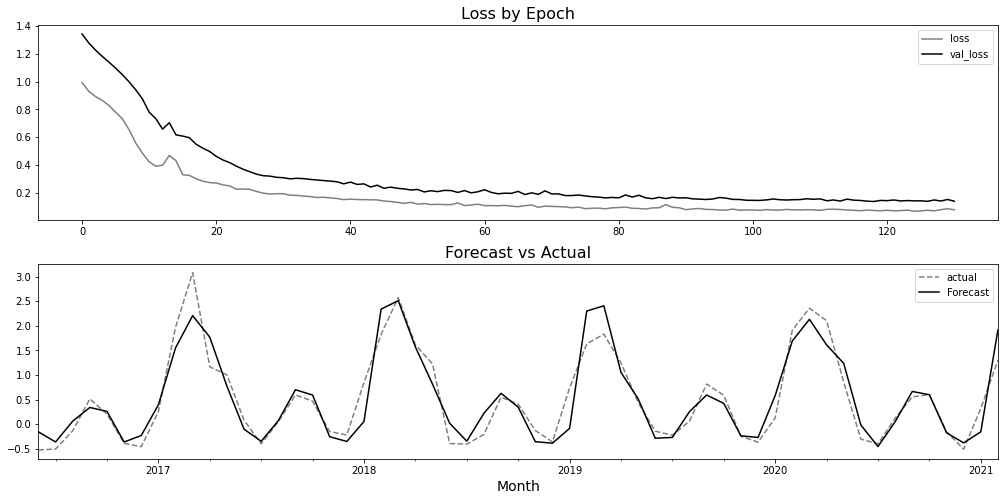

In [300]:
model_en_bd = create_model(x_train_en, units=32)
history_en_bd = train_model_ts(model_en_bd, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_bd, x_test_en, y_test_en, test_en.index, history_en_bd)

## Timedistributed

In [301]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    return model

### Air Passenger

In [302]:
tf.keras.backend.clear_session()

In [303]:
model_a_td = create_model(train=x_train_air, units=32)
history_a_td = train_model_ts(model_a_td, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 4s 267ms/step - loss: 0.9478 - root_mean_squared_error: 0.9736 - mean_absolute_error: 0.8069 - val_loss: 3.4900 - val_root_mean_squared_error: 1.8682 - val_mean_absolute_error: 1.6947
Epoch 2/500
4/4 [==============================] - 0s 24ms/step - loss: 0.8515 - root_mean_squared_error: 0.9228 - mean_absolute_error: 0.7567 - val_loss: 3.1598 - val_root_mean_squared_error: 1.7776 - val_mean_absolute_error: 1.5868
Epoch 3/500
4/4 [==============================] - 0s 23ms/step - loss: 0.7699 - root_mean_squared_error: 0.8775 - mean_absolute_error: 0.7108 - val_loss: 2.8290 - val_root_mean_squared_error: 1.6820 - val_mean_absolute_error: 1.4670
Epoch 4/500
4/4 [==============================] - 0s 22ms/step - loss: 0.6924 - root_mean_squared_error: 0.8321 - mean_absolute_error: 0.6642 - val_loss: 2.5001 - val_root_mean_squared_error: 1.5812 - val_mean_absolute_error: 1.3314
Epoch 5/500
4/4 [==============================] - 0s 22ms/step

In [304]:
model_a_td.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 29ms/step - loss: 2.7049 - root_mean_squared_error: 1.6447 - mean_absolute_error: 1.4744


[2.7049241065979004, 1.6446653604507446, 1.4743821620941162]

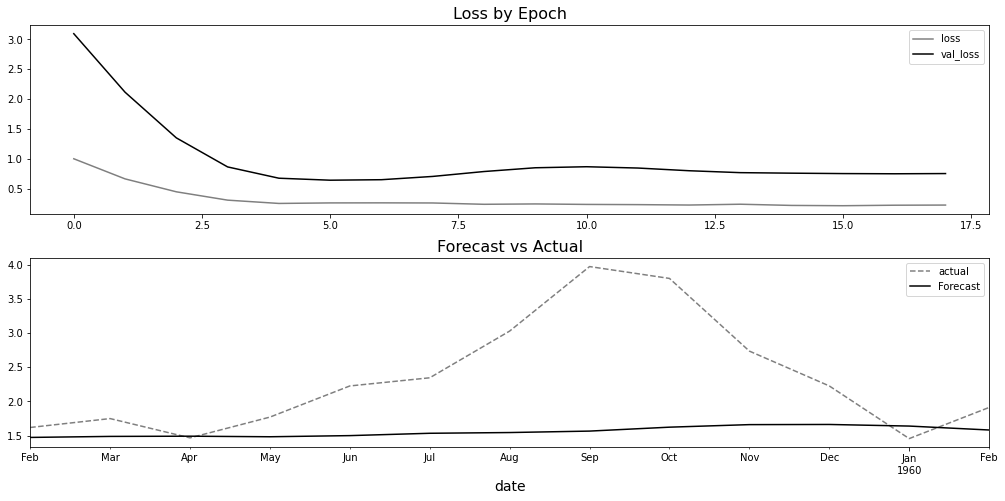

In [305]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [307]:
tf.keras.backend.clear_session()

In [308]:
model_dw_td = create_model(x_train_dw, units=32)
history_dw_td = train_model_ts(model_dw_td, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 4s 30ms/step - loss: 0.9295 - root_mean_squared_error: 0.9641 - mean_absolute_error: 0.7835 - val_loss: 0.8256 - val_root_mean_squared_error: 0.9086 - val_mean_absolute_error: 0.7450
Epoch 2/500
37/37 [==============================] - 0s 11ms/step - loss: 0.9134 - root_mean_squared_error: 0.9557 - mean_absolute_error: 0.7683 - val_loss: 0.8163 - val_root_mean_squared_error: 0.9035 - val_mean_absolute_error: 0.7421
Epoch 3/500
37/37 [==============================] - 0s 11ms/step - loss: 0.9081 - root_mean_squared_error: 0.9530 - mean_absolute_error: 0.7653 - val_loss: 0.8129 - val_root_mean_squared_error: 0.9016 - val_mean_absolute_error: 0.7403
Epoch 4/500
37/37 [==============================] - 0s 11ms/step - loss: 0.9039 - root_mean_squared_error: 0.9507 - mean_absolute_error: 0.7626 - val_loss: 0.8094 - val_root_mean_squared_error: 0.8996 - val_mean_absolute_error: 0.7387
Epoch 5/500
37/37 [==============================] - 0s 

### Energy Consumption

In [309]:
tf.keras.backend.clear_session()

In [310]:
model_en_td = create_model(x_train_en, units=32)
history_en_td = train_model_ts(model_en_td, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 [==============================] - 4s 108ms/step - loss: 1.0134 - root_mean_squared_error: 1.0067 - mean_absolute_error: 0.8161 - val_loss: 1.3946 - val_root_mean_squared_error: 1.1809 - val_mean_absolute_error: 0.8571
Epoch 2/500
8/8 [==============================] - 0s 16ms/step - loss: 0.9973 - root_mean_squared_error: 0.9986 - mean_absolute_error: 0.8127 - val_loss: 1.3855 - val_root_mean_squared_error: 1.1771 - val_mean_absolute_error: 0.8598
Epoch 3/500
8/8 [==============================] - 0s 16ms/step - loss: 0.9938 - root_mean_squared_error: 0.9969 - mean_absolute_error: 0.8142 - val_loss: 1.3759 - val_root_mean_squared_error: 1.1730 - val_mean_absolute_error: 0.8619
Epoch 4/500
8/8 [==============================] - 0s 15ms/step - loss: 0.9926 - root_mean_squared_error: 0.9963 - mean_absolute_error: 0.8161 - val_loss: 1.3678 - val_root_mean_squared_error: 1.1695 - val_mean_absolute_error: 0.8628
Epoch 5/500
8/8 [==============================] - 0s 13ms/step

## Compare

In [311]:
scores = pd.DataFrame(np.array(
    [model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_a_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_a_gru.evaluate(x=x_test_air, y=y_test_air),
    model_a_deep.evaluate(x=x_test_air, y=y_test_air),
    model_a_bd.evaluate(x=x_test_air, y=y_test_air),
    model_a_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM', 'Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')Ç

1/1 [==============================] - 0s 266ms/step - loss: 2.7049 - root_mean_squared_error: 1.6447 - mean_absolute_error: 1.4744


,MSE,RMSE,MAE
GRU,0.724080,0.850929,0.703160
SimpleRNN,1.206688,1.098493,0.974018
Bidirectional,1.208408,1.099276,0.805906
LSTM,1.229816,1.108971,0.811656
Deep LSTM,1.352662,1.163040,0.843578
TimeDistributed,2.704924,1.644665,1.474382


In [312]:
scores = pd.DataFrame(np.array(
    [model_dw_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_dw_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_dw_gru.evaluate(x=x_test_air, y=y_test_air),
    model_dw_deep.evaluate(x=x_test_air, y=y_test_air),
    model_dw_bd.evaluate(x=x_test_air, y=y_test_air),
    model_dw_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 286ms/step - loss: 3.0583 - root_mean_squared_error: 1.7488 - mean_absolute_error: 1.5320


,MSE,RMSE,MAE
Deep LSTM,0.667481,0.816995,0.601264
GRU,0.721008,0.849122,0.719908
LSTM,0.734652,0.857119,0.694010
SimpleRNN,0.831809,0.912036,0.759248
Bidirectional,1.032825,1.016280,0.842255
TimeDistributed,3.058280,1.748794,1.531964


In [313]:
scores = pd.DataFrame(np.array(
    [model_en_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_en_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_en_gru.evaluate(x=x_test_air, y=y_test_air),
    model_en_deep.evaluate(x=x_test_air, y=y_test_air),
    model_en_bd.evaluate(x=x_test_air, y=y_test_air),
    model_en_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 19ms/step - loss: 5.5759 - root_mean_squared_error: 2.3613 - mean_absolute_error: 2.1978


,MSE,RMSE,MAE
SimpleRNN,1.081594,1.039997,0.911351
GRU,1.515763,1.231163,1.072095
LSTM,3.644953,1.909176,1.806012
Deep LSTM,4.054580,2.013599,1.903199
Bidirectional,5.531262,2.351863,2.222646
TimeDistributed,5.575944,2.361344,2.197815


## How it works

In [ ]:
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)

In [279]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential(
        [SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])),
         Dropout(dropout),
         Dense(1)
        ]
    )
    
    return model

In [280]:
tf.keras.backend.clear_session()
model_a_simpleRNN_1 = create_model(train=x_train_air, units=32)
model_a_simpleRNN_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [281]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

tf.keras.backend.clear_session()
model_a_simpleRNN = create_model(train=x_train_air, units=32)
model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


## There is more

Using Keras Model API 

In [282]:
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.metrics import (RootMeanSquaredError, 
                                     MeanAbsoluteError)
from keras.layers import (Dense,  
                LSTM, Dropout, 
                Input, Activation)

In [229]:
from tensorflow.keras import Model
from keras.layers import (Dense,  
                SimpleRNN, Dropout, 
                Input)

def create_model(train, units, dropout=0.2):
    
    input_data = Input(shape=(10,1))
    rnn = SimpleRNN(units, return_sequences=True)(input_data)
    dropout = Dropout(dropout)(rnn)
    output = Dense(1)(dropout)
    model = Model(inputs=input_data, outputs=output)
    return model

In [266]:
from tensorflow.keras import Model
from keras.layers import (Dense,  
                SimpleRNN, Dropout, 
                Input)

def create_model(train, units, dropout=0.2):
    
    input_data = Input(shape=(10,1))
    lstm_1 = LSTM(units, return_sequences=True)(input_data)
    dropout_1 = Dropout(dropout)(lstm_1)
    lstm_2 = LSTM(units)(dropout_1)
    dropout_2 = Dropout(dropout)(lstm_2)
    output = Dense(1)(dropout_2)
    model = Model(inputs=input_data, outputs=output)
    
    return model

model_en_deep_lstm = create_model(train=x_train_en, units=32)
model_en_deep_lstm.summary()
history_en_deep_lstm = train_model_ts(model_en_deep_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 32)            4352      
                                                                 
 dropout_6 (Dropout)         (None, 10, 32)            0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable

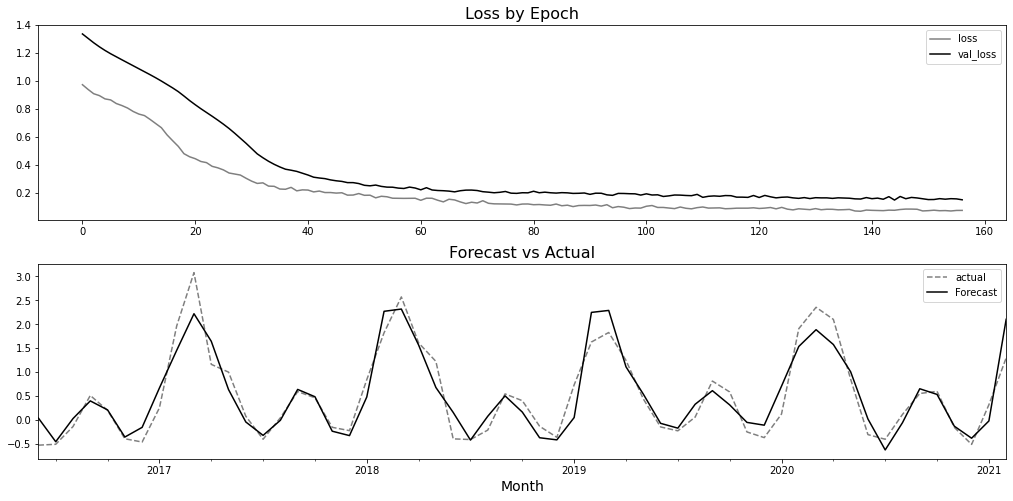

In [267]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

In [261]:
tf.keras.backend.clear_session()

In [262]:
model_a_m = create_model(train=x_train_air, units=32)
model_a_m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable p

### Air Passenger

In [263]:
history_a_m = train_model_ts(model_a_m, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 4s 268ms/step - loss: 0.7852 - root_mean_squared_error: 0.8861 - mean_absolute_error: 0.7216 - val_loss: 2.7564 - val_root_mean_squared_error: 1.6603 - val_mean_absolute_error: 1.4612
Epoch 2/500
4/4 [==============================] - 0s 21ms/step - loss: 0.6305 - root_mean_squared_error: 0.7940 - mean_absolute_error: 0.6346 - val_loss: 2.2059 - val_root_mean_squared_error: 1.4852 - val_mean_absolute_error: 1.2530
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.5003 - root_mean_squared_error: 0.7073 - mean_absolute_error: 0.5473 - val_loss: 1.6901 - val_root_mean_squared_error: 1.3000 - val_mean_absolute_error: 1.0195
Epoch 4/500
4/4 [==============================] - 0s 18ms/step - loss: 0.4023 - root_mean_squared_error: 0.6342 - mean_absolute_error: 0.4861 - val_loss: 1.2490 - val_root_mean_squared_error: 1.1176 - val_mean_absolute_error: 0.8155
Epoch 5/500
4/4 [==============================] - 0s 17ms/step

In [238]:
model_a_m.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 23ms/step - loss: 1.5109 - root_mean_squared_error: 1.2292 - mean_absolute_error: 0.9239


[1.5109097957611084, 1.229190707206726, 0.9239283204078674]

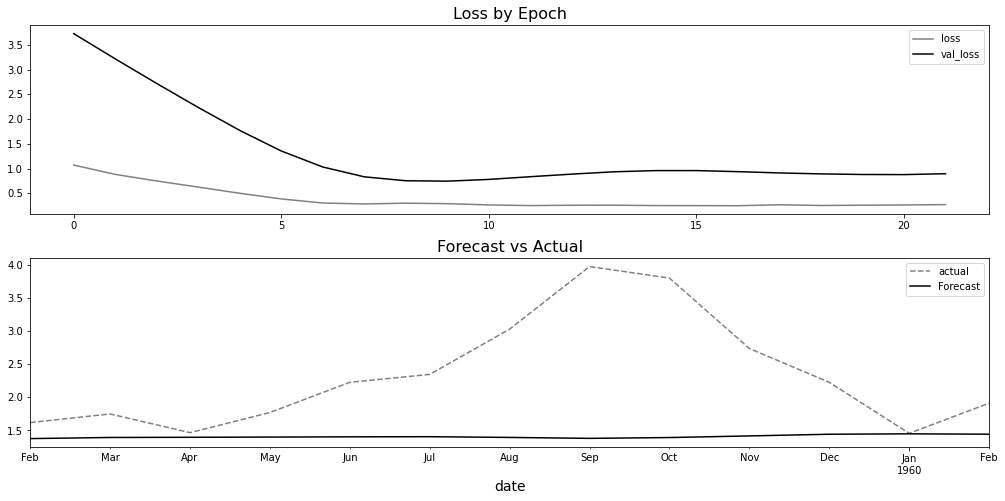

In [239]:
plot_forecast(model_a_m, x_test_air, y_test_air, test_air.index, history_a_m)